# Week 2 - SC PUK
We work with flux/charge basis and look at the hamiltonian of circuits.

In [77]:
import numpy as np
import matplotlib.pyplot as plt 

## Problem 1
Work with flux basis

In [220]:
# We define parameters
n       = 101
start   = - np.pi  
stop    = + np.pi

Ec      = 1
Ej      = 1

fluxes  = np.linspace(start, stop, n)

delta   = (stop - start) / (n - 1)


from scipy.sparse import diags
def kinetic_matrix(n = n, start = start, stop = stop, offset = 0):
    flux_elements   = np.linspace(start, stop, n)
    cosine_elements = np.cos(flux_elements + offset)

    return diags(cosine_elements)

def diff_conjugate_matrix(n = n, delta = delta):
    diag            = np.ones(n - 1)
    upper           = diags(diag,   -1)
    lower           = diags(-diag,  1)

    return - (1j)/(2 * delta) * (upper + lower)


def diff_diff_conjugate_matrix(n = n, delta = delta):
    diag            = - 2 * np.ones(n)
    diag            = diags(diag)
    off_diag        = np.ones(n - 1)
    upper           = diags(off_diag,   -1)
    lower           = diags(off_diag,   1)

    return - (1)/(delta ** 2) * (diag + upper + lower)


def Hamiltonian(Josephson_energy = 1, charge_energy = 1, flux_offset = 0):
    kin =  - Josephson_energy * kinetic_matrix(offset = flux_offset)
    pot = charge_energy * diff_diff_conjugate_matrix()
    return 4 * kin + pot
    
from scipy.sparse.linalg import eigsh
def get_states_with_flux(flux_offset, **kwargs):
    H = Hamiltonian(flux_offset = flux_offset, **kwargs)
    Es, vects = eigsh(H)
    return Es[[0, 1]], vects[:, [0,1]]

In [221]:
from scipy.sparse.linalg import eigsh
Es, vects = eigsh(Hamiltonian(), which = "SM", return_eigenvectors= True)

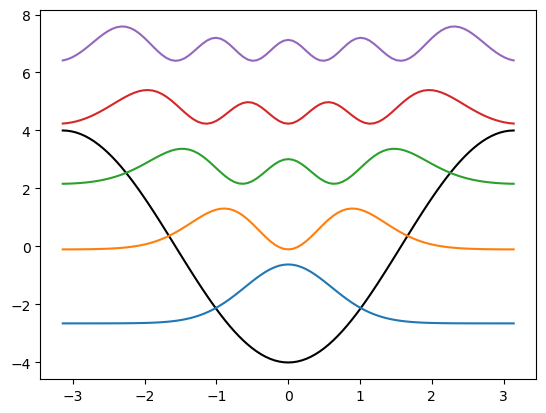

In [222]:
plt.plot(fluxes, - 4 * Ej * np.cos(fluxes), color = "k")

for i in range(5):
    plt.plot(fluxes, Es[i] + 50 * abs(vects[:, i]) ** 2)

## Problem 2
Here we deal with noise.

In [223]:
# Define the used constants:
# Units of phi0
A_flux      = 1e-6
A_charge    = 1e-4
B_charge    = 5.2e-9

# Power spectrum:
def S_flux(omega):
    return 2 * np.pi * A_flux ** 2 / np.abs(omega)

def S_charge(omega):
    return 2 * np.pi * A_charge ** 2 / np.abs(omega)

def S_ohm(omega):
    return B_charge ** 2 * omega / 2 * np.pi / 1e9

We find the ground and excited states numerically and can now calculate the 

In [226]:
def time_flux(fluxes):
    calculated_time = []
    for flux in fluxes:
        Es, eigenstates     = get_states_with_flux(flux)
        state0      = eigenstates[:, 0]
        state1      = eigenstates[:, 1]

        omega       = Es[1] - Es[0]

        dH_dphi     = diags(np.sin(np.linspace(start, stop, n)))
        
        matrix_element  = np.conjugate(state0) @ dH_dphi @ state1

        gamma       = abs(matrix_element) ** 2 * S_flux(omega)

        calculated_time.append(1 / gamma)

    return np.array(calculated_time)

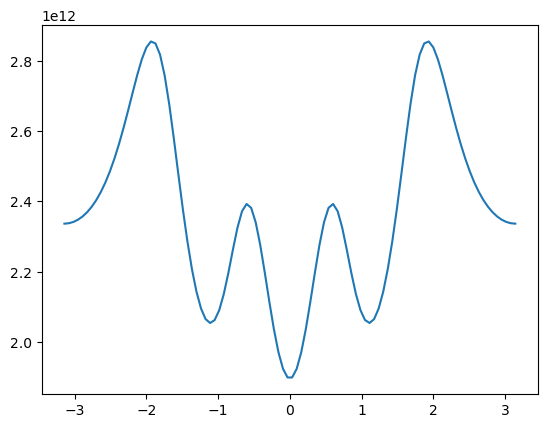

In [231]:
offsets = np.linspace(-np.pi, np.pi, 100)
times = time_flux(fluxes = offsets)
plt.plot(offsets, times)

In [118]:
# Define the charge basis instead:
lower_cut   = -10
higher_cut  = 10

Ec          = 1
Ej          = 1

e = 1

def charge_diag(lower = lower_cut, higher = higher_cut):
    diag = 2 * e * diags(np.arange(lower_cut, higher_cut + 1))
    return diags

def cos_in_charge_basis(lower = lower_cut, higher = higher_cut):
    n           = higher - lower
    off_diag    = diags(np.ones(n - 1), offsets = 1) / 2
    
    return off_diag + off_diag.T

def Hamiltonian(Ec, Ej, lower_cut = lower_cut, higher_cut = higher_cut):
    diag        = charge_diag(lower_cut, higher_cut)
    cos_term    = cos_in_charge_basis(lower_cut, higher_cut)

    H           = 4 * Ec * diag - Ej * cos_term
    return H

In [ ]:
def T1_charge(omega, EC, n):
    Gamma1 =  (8 * EC * n)  